<a href="https://colab.research.google.com/github/farfaness/Machine_learning/blob/master/Prediction_of_DSI_ticket_time_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse & Visualisation 

**Pour prédire le temps de résolution d'un ticket DSI**. 

Selon les informations reçues du client : 
- les données couvrent la période allant de janvier 2015 à novembre 2018 inclus
- Au total, il devrait y avoir ~ 86 000 lignes de données
- les lignes sont triées par ordre chronologique croissant
- mêmes attributs de données que ceux fournis / expliqués précédemment

Vérifions les réclamations de notre cher client et recherchons une date limite convenable !


## Organisation du notebook 
Ce notebook est organisé par cellules, avec des consignes et des outputs pour vous montrer à quoi doivent ressembler les résultats. 

### Data
Les variables sont : 
- timestamp: Contains the date and time of each single ticket change. 
- work_item: The unique ID of a support ticket.
- work_type: What kind of ticket (e.g. hotfix, bug, change request)
- work_priority: How important the ticket is. Lower numbers mean more important.
- domain: From which business area is the ticket
- platform: From which platform is the ticket
- components: Which components are affected by the ticket
- from_phase: The phase in which the ticket was before the change. Note that a missing value denotes a new ticket.
- to_phase: The phase in which the ticket was after the change. Note that a missing value denotes that the ticket was closed
- from_resource: The ID of the resource (i.e. person) who was working on the ticket till now
- to_resource: The ID of the resource (i.e. person) who will now work on this ticket

At first glance it seems that the most important columns are timestamp and work_item. Timestamp will define the values we have to predict, work_item sets the IDs. The remaining columns contain information that can be used as features for our model.

____________________________________

## Import et analyse préliminaire 

In [0]:
#Importer les librairies qui vous semble utiles 
import warnings
warnings.simplefilter("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import date, time, datetime, timedelta

In [0]:
#Charger le dataset `20181130_Full_Dataset.xlsx`
data = pd.read_excel('/content/20181130_Full_Dataset.xlsx')
data.head(5)

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource
0,2015-01-02 14:39:14,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,NaN,NaN,Analyze,NaN,ER_00043
1,2015-01-02 15:04:20,WI_000002,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,NaN,Analyze,NaN,ER_00225
2,2015-01-02 15:28:22,WI_000003,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,NaN,Analyze,NaN,ER_00225
3,2015-01-02 15:33:54,WI_000004,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,NaN,Analyze,NaN,ER_00225
4,2015-01-02 16:32:11,WI_000005,WT_00002,WP_00003,BD_00003,PL_00003,CO_00113,NaN,Analyze,NaN,ER_00206


In [0]:
#Afficher les informations du dataset 
data.info(memory_usage = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85794 entries, 0 to 85793
Data columns (total 11 columns):
timestamp        85794 non-null datetime64[ns]
work_item        85794 non-null object
work_type        85794 non-null object
work_priority    85794 non-null object
domain           85794 non-null object
platform         85794 non-null object
components       59497 non-null object
from_phase       72097 non-null object
to_phase         73284 non-null object
from_resource    72097 non-null object
to_resource      73284 non-null object
dtypes: datetime64[ns](1), object(10)
memory usage: 7.2+ MB


In [0]:
#Afficher les stat descriptive 
data.describe() 

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource
count,85794,85794,85794,85794,85794,85794,59497,72097,73284,72097,73284
unique,85260,13697,3,5,11,19,366,8,8,299,308
top,2018-02-26 10:12:33,WI_006500,WT_00001,WP_00003,BD_00002,PL_00002,CO_00118,Analyze,Analyze,ER_00239,ER_00239
freq,10,34,33212,42797,17841,17841,4923,14223,14884,3143,3155
first,2015-01-02 14:39:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2018-11-30 18:52:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#Regarder le 'work_item' WI_005405
#Que remarquez vous ? 
def delay(ID):
  tickets = data.loc[data.work_item == ID].index
  time_send = data['timestamp'][tickets[0]]
  time_closed = data['timestamp'][tickets[-1]]
  delay = time_closed - time_send
  print('Le ticket {} est résolu en {} jours et {} secondes ' .format(ID, delay.days, delay.seconds))

delay("WI_005405")

#pd.set_option('display.max_rows', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 11)

print(data[data.work_item == "WI_005405"][data.columns])

Le ticket WI_005405 est résolu en 0 jours et 4 secondes 
                timestamp  work_item work_type work_priority    domain  \
32621 2016-11-16 14:53:35  WI_005405  WT_00001      WP_00002  BD_00008   
32622 2016-11-16 14:53:39  WI_005405  WT_00001      WP_00002  BD_00008   

       platform components from_phase to_phase from_resource to_resource  
32621  PL_00014        NaN        NaN  Analyze           NaN    ER_00284  
32622  PL_00014        NaN    Analyze      NaN      ER_00284         NaN  


In [0]:
#Pareil pour le 'WI_000273' 
#Que remarquez vous par rapport à 'WI_005405'? 
delay("WI_000273")

print(data[data.work_item == "WI_000273"][data.columns])

Le ticket WI_000273 est résolu en 1281 jours et 52999 secondes 
                timestamp  work_item work_type work_priority    domain  \
1165  2015-02-02 19:58:53  WI_000273  WT_00003      WP_00002  BD_00007   
1184  2015-02-03 10:38:27  WI_000273  WT_00003      WP_00002  BD_00007   
26789 2016-08-01 17:04:51  WI_000273  WT_00003      WP_00002  BD_00007   
26790 2016-08-01 17:05:13  WI_000273  WT_00003      WP_00002  BD_00007   
26791 2016-08-01 17:05:17  WI_000273  WT_00003      WP_00002  BD_00007   
26792 2016-08-01 17:05:24  WI_000273  WT_00003      WP_00002  BD_00007   
43738 2017-05-03 14:42:20  WI_000273  WT_00003      WP_00002  BD_00007   
57574 2017-10-30 16:11:27  WI_000273  WT_00003      WP_00002  BD_00007   
71819 2018-03-29 13:39:26  WI_000273  WT_00003      WP_00002  BD_00007   
75189 2018-05-23 07:35:57  WI_000273  WT_00003      WP_00002  BD_00007   
75190 2018-05-23 07:36:01  WI_000273  WT_00003      WP_00002  BD_00007   
76698 2018-06-14 12:30:48  WI_000273  WT_00003  

### Focus sur les variables 
Explorer les différentes variables du dataset, les décrire et les ploter à l'aide de la librairie de votre choix. **Ci-dessous quelques exemples de plot, n'hésitez pas à explorer le dataset** 

In [0]:
for colonne in data.columns : 
  nbr_unique_value = len(data[colonne].value_counts())
  print("La colonne {} comporte {} valeurs uniques" .format(colonne, nbr_unique_value))
  if nbr_unique_value < 10 : print(data[colonne].value_counts())
  elif (data[colonne].dtype == object) : print(data[colonne].value_counts())
  else :  print(data[colonne].value_counts(bins = 15)) #Lorsque beaucoup de valeurs pour une variable num me les regroupe en 15 bins
  print('\n')

La colonne timestamp comporte 85260 valeurs uniques
(2017-11-14 22:33:01.400000, 2018-02-18 03:37:54.800000]       9233
(2017-08-11 17:28:08, 2017-11-14 22:33:01.400000]              8011
(2017-05-08 12:23:14.600000, 2017-08-11 17:28:08]              7183
(2018-02-18 03:37:54.800000, 2018-05-24 08:42:48.200000]       6879
(2017-02-02 07:18:21.200000, 2017-05-08 12:23:14.600000]       6767
(2016-01-18 10:58:47.600000, 2016-04-22 16:03:41]              6028
(2018-05-24 08:42:48.200000, 2018-08-27 13:47:41.600000]       5444
(2016-10-30 02:13:27.800000, 2017-02-02 07:18:21.200000]       5370
(2016-07-26 21:08:34.400000, 2016-10-30 02:13:27.800000]       5227
(2018-08-27 13:47:41.600000, 2018-11-30 18:52:35]              5051
(2015-10-15 05:53:54.200000, 2016-01-18 10:58:47.600000]       4660
(2016-04-22 16:03:41, 2016-07-26 21:08:34.400000]              4616
(2015-01-01 04:22:39.599000063, 2015-04-07 19:44:07.400000]    4387
(2015-04-07 19:44:07.400000, 2015-07-12 00:49:00.800000]       3

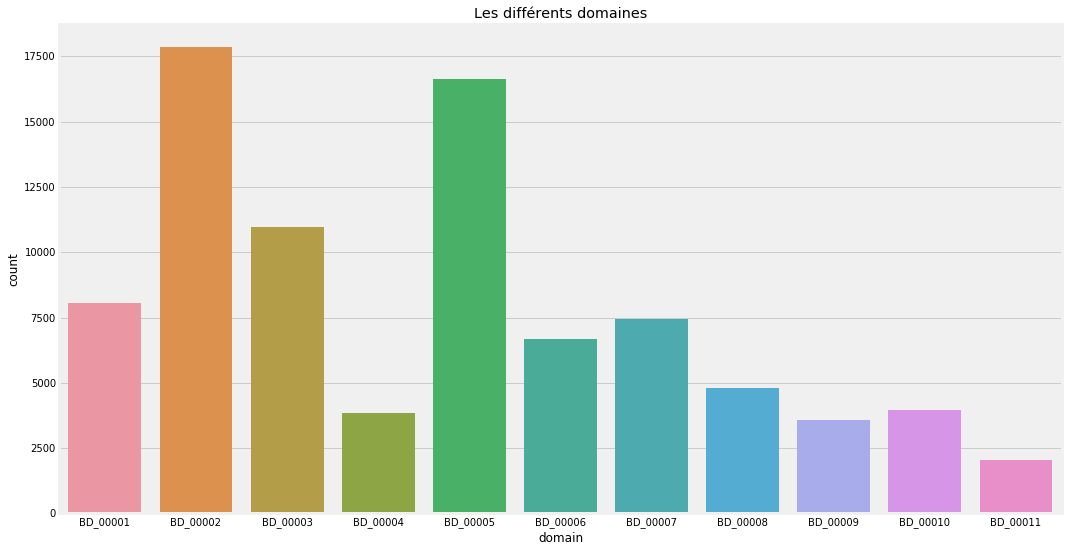

In [0]:
l=['domain']

for i in l :
    sns.set(rc={"figure.figsize": [10, 5]})
    fig = sns.countplot(data[i])
    plt.xticks(rotation=45)
    plt.show()
    
#ou
#for i in dataframe.columns.tolist():
#  if dataframe[i].dtype == 'object': #le faire uniquement sur les variables catégorielles
#    sns.countplot(i, data = dataframe)
#    plt.show()


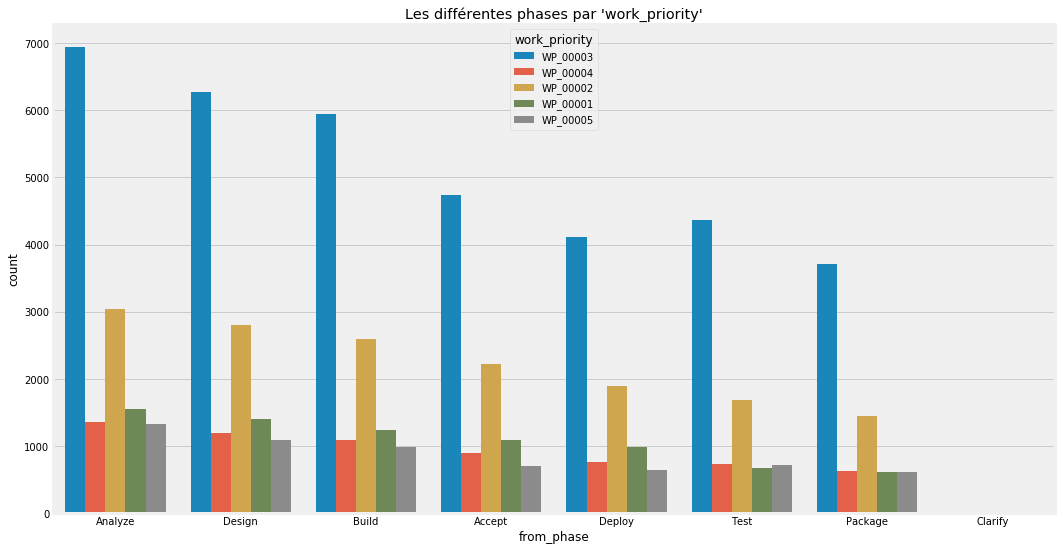

In [0]:
sns.set(rc={"figure.figsize": [15, 10]})
fig = sns.countplot(data['from_phase'], hue = data['work_priority'])
plt.xticks(rotation=45)
plt.show()

Regardons le dataset plus en détail notamment : 
- l'ordre chronologique des lignes  
- les dates minimales et maximales couvertes dans le jeu de données 
- les éléments de travail uniques qui sont dans l'ensemble de données 
- le nombre total d'éléments de travail ouverts et fermés, et le nombre de travaux en cours à la date maximale


In [0]:
#Filtrer le dataframe pour compter les NaN dans la colonne from_phase   
#value_counts de toutes les lignes ayant un nan dans la colonne from_phase et pas de nan dans from_resource

mask = (data['from_phase'].isna() == True) & (data['from_resource'].isna() == False)
df = data.loc[mask]

#Select the tickets openned between these two dates
df.isna().sum(axis = 0)

#ou
#data[data['from_phase'].isnull()].count()

timestamp        0
work_item        0
work_type        0
work_priority    0
domain           0
platform         0
components       0
from_phase       0
to_phase         0
from_resource    0
to_resource      0
dtype: int64

In [0]:
#Filtrer le dataframe pour compter les NaN dans la colonne to_phase   
mask = (data['to_phase'].isna() == True) & (data['to_resource'].isna() == False)
df = data.loc[mask]

#Select the tickets openned between these two dates
df.isna().sum(axis = 0)

#data[data['to_phase'].isnull()].count()

timestamp        0
work_item        0
work_type        0
work_priority    0
domain           0
platform         0
components       0
from_phase       0
to_phase         0
from_resource    0
to_resource      0
dtype: int64

In [0]:
#Retrouver la date la plus ancienne dans le dataset
min_date = min(data['timestamp'])
min_date

Timestamp('2015-01-02 14:39:14')

In [0]:
#Retrouver la date la plus la plus récente dans le dataset
max_date = max(data['timestamp'])
max_date

Timestamp('2018-11-30 18:52:35')

In [0]:
#Trier le dataset par date croissante
data_ordonne = data.sort_values(by='timestamp')

In [0]:
#Compter les `work_item` unique 
#Que remarquez vous 
print(len(data_ordonne['work_item'].value_counts()))

13697


In [0]:
#Compter les tickets ouverts durant la période du 2015-01-02 au 2018-11-30 
#Select the tickets between these two dates
mask = (data['timestamp'] >= min_date) & (data['timestamp'] <= max_date)
df = data.loc[mask]

#Select the tickets openned between these two dates
print(len(df[df['from_phase'].isna() == True]))

df[df.from_phase.isnull()].work_item.count() #mieux car unique nan pour unique work_item

13697


In [0]:
#Compter les tickets fermés sur cette même période 
print(len(df[df['to_phase'].isna() == True]))

df[df.to_phase.isnull()].work_item.count()

12510


In [0]:
#Compter les tickets qui sont restés ouvert (les Work In Progress tickets)
#Que pouvez vous conclure  ? 
print(len(df[df['from_phase'].isna() == True]) - len(df[df['to_phase'].isna() == True]))

1187


### Check des "valeurs manquantes"

In [0]:
#compter les NaN par variables  
data.isna().sum(axis = 0)

timestamp            0
work_item            0
work_type            0
work_priority        0
domain               0
platform             0
components       26297
from_phase       13697
to_phase         12510
from_resource    13697
to_resource      12510
dtype: int64

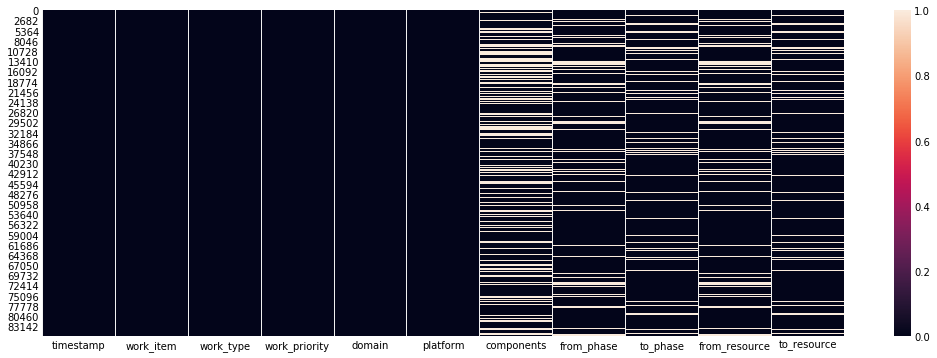

In [0]:
#Afficher une heatmap de ces valeurs 
sns.heatmap(data.isna())

________________________________________

## Feature Engineering n°1 : Agrégation 

Pour cette analyse, nous ne nous intéressons qu'aux éléments de travail (tickets) entrant et sortant du processus de fin de cycle.

Sachant que : 
- lorsqu'un élément de travail entre dans le process, la variable `from_phase` contient une valeur null
- quand un élément quitte le processus, la variable `to_phase` contient une valeur null

On va donc utiliser ces connaissances pour regrouper rapidement les varibales présentant un intérêt pour notre étude.

In [0]:
#Sélectionner un sous échantillon aléatoire de taille 10 dans le dataset  
random_10 = data.loc[np.random.choice(df.index, 10, replace=False)]  #Pas de remise, évite répétition
random_10.head(10)

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource
23775,2016-05-25 15:43:35,WI_003994,WT_00003,WP_00002,BD_00003,PL_00008,CO_00118,Analyze,Design,ER_00238,ER_00212
77784,2018-06-27 15:03:40,WI_012440,WT_00003,WP_00003,BD_00002,PL_00002,CO_00069,Package,Accept,ER_00217,ER_00217
43810,2017-05-04 10:10:47,WI_007241,WT_00001,WP_00004,BD_00005,PL_00005,CO_00164,Test,Package,ER_00222,ER_00222
2848,2015-03-09 13:42:48,WI_000559,WT_00003,WP_00001,BD_00007,PL_00007,NaN,Test,Package,ER_00198,ER_00198
61205,2017-11-29 16:51:53,WI_009834,WT_00003,WP_00001,BD_00008,PL_00013,NaN,Deploy,NaN,ER_00221,NaN
18243,2016-02-19 11:53:47,WI_002443,WT_00002,WP_00002,BD_00011,PL_00018,NaN,Design,Build,ER_00215,ER_00215
57600,2017-10-30 17:01:44,WI_009560,WT_00003,WP_00004,BD_00002,PL_00002,CO_00153,Analyze,Design,ER_00110,ER_00239
17975,2016-02-15 18:54:27,WI_003046,WT_00001,WP_00005,BD_00007,PL_00012,CO_00098,Design,Build,ER_00060,ER_00146
68140,2018-02-13 09:09:38,WI_010207,WT_00001,WP_00003,BD_00006,PL_00006,NaN,Deploy,Accept,ER_00108,ER_00099
15876,2016-01-14 15:16:06,WI_002254,WT_00001,WP_00003,BD_00004,PL_00011,NaN,Package,Accept,ER_00073,ER_00073


In [0]:
#Définir des filtre sur les 'NaN' qui vont servir à construire un nouveau dataset avec les entrées et sorties des tickets
#Aider vous de la description sur le dataset et des questions précédentes
#Que remarquez vous ? 

# filtre 1
#filtre_openned = data.loc[data['from_phase'].isna() == True].index
#print(filtre_openned.value_counts())
print((data['from_phase'].isna() == True).value_counts())

#filtre 2
print((data['to_phase'].isna() == True).value_counts())

False    72097
True     13697
Name: from_phase, dtype: int64
False    73284
True     12510
Name: to_phase, dtype: int64


### Les phases de travail 
Les différentes phases d'un 'work_item' sont des indicateurs majeurs de ce "qu'est vraiment" cette variable 'work_item'. Voyons donc les relations (si existante) entre les différente phases. 

#### Le problème des NaN 
Les variables from_phase et to_phase pausent problème car les NaN comme vous l'avez compris sont des informations importantes.

In [0]:
#Remplacer les NaN des colonnes from_phase et to_phase par 'start' et 'end'
#À votre avis pourquoi ce remplacement?  Plus clair car ces NaN sont des informations

# Tickets start
data['from_phase'].fillna('start', axis = 0, inplace = True) #index not columns to replace
print(data['from_phase'].isna().sum())
print(data['from_phase'].value_counts())

# Tickets end
data['to_phase'].fillna('end', axis = 0, inplace = True) 
print(data['to_phase'].isna().sum())
print(data['to_phase'].value_counts())

0
Analyze    14223
start      13697
Design     12763
Build      11846
Accept      9642
Deploy      8405
Test        8196
Package     7020
Clarify        2
Name: from_phase, dtype: int64
0
Analyze    14884
Design     12924
end        12510
Build      11964
Accept      9734
Deploy      8489
Test        8258
Package     7028
Clarify        3
Name: to_phase, dtype: int64


In [0]:
#Voir les différentes valeurs possible suivants les phases (from_phase & to_phase)
#Que remarquez vous ?  #même ordre croissant = chemin des tickets

print(data['from_phase'].value_counts())
print('\n')
print(data['to_phase'].value_counts())

Analyze    14223
start      13697
Design     12763
Build      11846
Accept      9642
Deploy      8405
Test        8196
Package     7020
Clarify        2
Name: from_phase, dtype: int64


Analyze    14884
Design     12924
end        12510
Build      11964
Accept      9734
Deploy      8489
Test        8258
Package     7028
Clarify        3
Name: to_phase, dtype: int64


#### Une phase oui ? Mais de quoi ? 

In [0]:
#Afficher un tableau croisé entre 'from_phase' et 'to_phase'
#Que remarquez vous ? 
#Essayer d'intuiter un "chemin" pour un work_item  

pd.crosstab(data.from_phase,data.to_phase) 

to_phase,Accept,Analyze,Build,Clarify,Deploy,Design,Package,Test,end
from_phase,,,,,,,,,
Accept,0,0,0,0,7872,0,0,1770,0
Analyze,0,224,12,3,0,11936,0,0,2048
Build,3761,2,0,0,0,925,0,6367,791
Clarify,0,2,0,0,0,0,0,0,0
Deploy,196,0,0,0,0,0,0,0,8209
Design,0,959,10784,0,0,63,0,1,956
Package,5777,0,0,0,617,0,0,120,506
Test,0,0,1168,0,0,0,7028,0,0
start,0,13697,0,0,0,0,0,0,0


Un work_item commence par être analysé, ensuite le service analyse demande parfois clarification ou l'envoi vers le service pertinent (autre service d'analyse, build, design, ou clos le ticket). Ensuite le work item peut soit être amené à voyager entre les services build et design, soit être clos, être réanalysé, ou être soumis au services Accept ou Test. Le service accept peut ensuite l'envoyer en Deployement ou test, et le service test peut ensuite l'envoyer vers le service Package (ou build si besoin de finalisation). Le service package pourra ensuite l'envoyer vers Accept, Deploy ou test. Le service Deploy envoi vers Accept ou cloturer le ticket.

En résumé, le service analyse est le point de départ de tout les tickets. Les tickets voyagent ensuite entre les services build et design selon les besoins. Et en bout de chaine on retrouve les services Accept, le service de deployement, de test et de package.

Chemin classique = suivre le mode dans chaque ligne, soit : start, analyze, design, build, test, package, accept, deploy, end

#### Et les fonctions dans tout ca ? 

In [0]:
#Définir une fonction qui prend un dataframe afin d'agréer les données et de savoir
#Si le work_item est fermé 
#Le nombre de phase par lequel le work_item est passé 
#Le nombre unique de phase 
#
#--->La fonction devra ressortir une pandas series

def statut(dataframe):  
  infos = []
  ID = dataframe['work_item'].unique()

  for work_item in ID :
    lignes_ticket = dataframe.loc[dataframe.work_item == work_item].index #retrieve indexs of the ticket with his ID

    # statut : ticket closed ?
    if dataframe['to_phase'][lignes_ticket[-1]] == 'end' : statut = 'closed'
    else : statut = 'in_progress'

    #nbr phases
    phases = []
    [phases.append(dataframe['to_phase'][x]) for x in lignes_ticket[0:-1]]
    nbr_phase = len(phases)
    nbr_unique_phase = len(set(phases))

    # Put the infos on the ticket in a list
    liste = []
    liste = [work_item, statut, nbr_phase, nbr_unique_phase]

    # Append the liste in a list for all the tickets
    infos.append(liste)

  #Create serie from the list with all the tickets
  closed = pd.DataFrame(infos, columns = ['ID_work_item', 'statut', 'nbr_phase', 'nbr_unique_phase']) 
  closed.set_index('ID_work_item', inplace=True, drop = True)
  return closed

closed = statut(data)
closed.head(5)

###########################################################################
#ou sinon:
def aggregation(x:pd.DataFrame)->pd.Series:  #force à avoir un dataframe en entrée et une séries en sortie
    names = {
        'was_closed': max(x['to_phase'] == 'End'),
        'nr_of_phases': len(x),  # Not counting the start phase
        'unique_phases': x['from_phase'].nunique()  # Not counting the end phase
        }
    return pd.Series(names)
  
df_work_item_agg = data.groupby('work_item').apply(aggregation)

,statut,nbr_phase,nbr_unique_phase
ID_work_item,,,
WI_000001,closed,11,7
WI_000002,closed,3,3
WI_000003,closed,7,5
WI_000004,closed,7,7
WI_000005,closed,7,5


In [0]:
closed['statut'].value_counts()

closed         12510
in_progress     1187
Name: statut, dtype: int64

In [0]:
#Grouper vos données afin d'appliquer la fonction 
closed.head(5)

,statut,nbr_phase,nbr_unique_phase
ID_work_item,,,
WI_000001,closed,11,7
WI_000002,closed,3,3
WI_000003,closed,7,5
WI_000004,closed,7,7
WI_000005,closed,7,5


In [0]:
print(data[data.work_item == 'WI_000001'])

              timestamp  work_item work_type work_priority    domain  \
0   2015-01-02 14:39:14  WI_000001  WT_00001      WP_00003  BD_00001   
24  2015-01-05 11:48:08  WI_000001  WT_00001      WP_00003  BD_00001   
29  2015-01-05 12:35:59  WI_000001  WT_00001      WP_00003  BD_00001   
140 2015-01-07 11:04:51  WI_000001  WT_00001      WP_00003  BD_00001   
145 2015-01-07 14:04:44  WI_000001  WT_00001      WP_00003  BD_00001   
146 2015-01-07 14:07:56  WI_000001  WT_00001      WP_00003  BD_00001   
149 2015-01-07 14:37:35  WI_000001  WT_00001      WP_00003  BD_00001   
333 2015-01-13 10:25:36  WI_000001  WT_00001      WP_00003  BD_00001   
473 2015-01-15 11:04:02  WI_000001  WT_00001      WP_00003  BD_00001   
591 2015-01-19 08:54:54  WI_000001  WT_00001      WP_00003  BD_00001   
633 2015-01-20 11:11:48  WI_000001  WT_00001      WP_00003  BD_00001   
858 2015-01-27 11:36:51  WI_000001  WT_00001      WP_00003  BD_00001   

     platform components from_phase to_phase from_resource to_r

## Nos filtres dans tout ça   
On voudrait savoirmaintenant pour chaque work_item le temps associé à sa résolution, on va pour cela **construire un nouveau dataset avec seulement les données qui sont pertinentes.**

In [0]:
#Définir une liste de variables à utiliser pour notre problème
subset_data = data[['work_item', 'timestamp']]
subset_data.head(2)

,work_item,timestamp
0,WI_000001,2015-01-02 14:39:14
1,WI_000002,2015-01-02 15:04:20


In [0]:
#Appliquer un filtre ci-dessus sur les variables choisis (variables ci-dessus) du dataset et afficher les 5 premières lignes

#List of index of the tickets closed
select_ID =closed[closed['statut'] == 'closed'].index.tolist() 
#select_ID = closed.index.where(closed["statut"] == 'closed').tolist() # Même chose

filtred_subset_data = subset_data.loc[subset_data['work_item'].isin(select_ID)]

print(len(filtred_subset_data['work_item'].unique()))
filtred_subset_data.head(5)

#Autre méthode si on avait travaillé avec les index de nos lignes
#filtred_subset_data = subset_data.loc[list_of_index, :] # les : indiquent que l'on prend toutes les colonnes

12510


,work_item,timestamp
0,WI_000001,2015-01-02 14:39:14
1,WI_000002,2015-01-02 15:04:20
2,WI_000003,2015-01-02 15:28:22
3,WI_000004,2015-01-02 15:33:54
4,WI_000005,2015-01-02 16:32:11


In [0]:
#Construire un nouveau dataframe à partir des attribut et des filtres ci-dessus
#Vous l'avez sans doute compris 
#le nouveau dataframe regroupe les entrées et sorties des tickets par work_item

new_dataset = data.loc[data['from_phase'].isin(['start']) | data['to_phase'].isin(['end'])] #On garde que les lignes avec start ou end
 
ID = new_dataset['work_item'].unique() #ID de nos tickets
infos = []
  
for work_item in ID :
  lignes_ticket = new_dataset.loc[new_dataset.work_item == work_item].index #retrieve indexs of the ticket with his ID
   
  for x in lignes_ticket:
    exit_time = 'no_exit' #for the tickets still in processing
    if new_dataset['from_phase'][x] == 'start' : entry_time = new_dataset.timestamp[x]
    elif new_dataset['to_phase'][x] == 'end' : exit_time = new_dataset.timestamp[x]  
  
  # Put the infos on the ticket in a list
  liste = []
  liste = [work_item, entry_time, exit_time]

  # Append the liste in a list for all the tickets
  infos.append(liste)

#Create serie from the list with the tickets IDs and their time infos
data_time = pd.DataFrame(infos, columns = ['work_item', 'entry_time', 'exit_time']) 

print('Le dataset à donc {} lignes' .format(len(data_time)))
#data_time.resetindex(drop = True)

#####################################################################################################
# ou faisable avec un merge

Le dataset à donc 13697 lignes


In [0]:
data_time.head(5)

,work_item,entry_time,exit_time
0,WI_000001,2015-01-02 14:39:14,2015-01-27 11:36:51
1,WI_000002,2015-01-02 15:04:20,2015-01-14 09:46:37
2,WI_000003,2015-01-02 15:28:22,2015-02-26 11:50:37
3,WI_000004,2015-01-02 15:33:54,2015-01-28 09:11:05
4,WI_000005,2015-01-02 16:32:11,2015-02-04 12:57:49


In [0]:
#Créer un nouvelle varibale dans votre dataframe 
#cette variable indiquera le nombre de jour de l'entrée et la sortie du ticket 
#créer ensuite une variable qui indique la durée en jours et en jours h min sec

liste = []
[liste.append(data_time['exit_time'][x] - data_time['entry_time'][x]) if data_time['exit_time'][x]!= 'no_exit' else liste.append(np.nan) for x in data_time.index]
data_time['duration'] = liste

liste = []
[liste.append(round(data_time['duration'][x].days + (data_time['duration'][x].seconds/60/60/24), 2)) for x in data_time.index]
data_time['duration_in_days'] = liste


data_time.head(5)

,work_item,entry_time,exit_time,duration,duration_in_days
0,WI_000001,2015-01-02 14:39:14,2015-01-27 11:36:51,24 days 20:57:37,24.87
1,WI_000002,2015-01-02 15:04:20,2015-01-14 09:46:37,11 days 18:42:17,11.78
2,WI_000003,2015-01-02 15:28:22,2015-02-26 11:50:37,54 days 20:22:15,54.85
3,WI_000004,2015-01-02 15:33:54,2015-01-28 09:11:05,25 days 17:37:11,25.73
4,WI_000005,2015-01-02 16:32:11,2015-02-04 12:57:49,32 days 20:25:38,32.85


### Focus sur le temps de résolution d'un ticket 
Examinons de plus près le délai total des différents éléments de travail, c'est-à-dire **le temps qui s'écoule entre la création et la fermeture d'un ticket.**

In [0]:
#Afficher les stat descriptive de la variable 'duration'
#Que remarquez vous ? 
data_time['duration'].describe()

count                       12510
mean      62 days 21:32:47.226618
std      116 days 15:42:38.288169
min               0 days 00:00:04
25%        4 days 23:01:04.250000
50%       20 days 02:48:47.500000
75%              67 days 23:54:53
max            1281 days 14:43:19
Name: duration, dtype: object

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


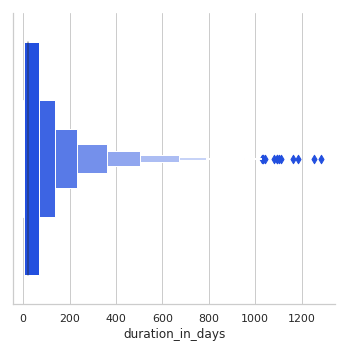

In [0]:
#Afficher une boite à moustache sur votre nouvelle variable 'duration_in_days' 
#Que remarquez vous ? 

sns.set(style="whitegrid", rc={'figure.figsize':(15,8)})
#ax = sns.boxenplot(x=data_time["duration_in_days"], linewidth=0)

#from matplotlib import rcParams
#rcParams['figure.figsize'] = 15,15

ax = sns.catplot(x = "duration_in_days", kind = 'boxen', data = data_time, palette='bright')
#plt.rc('figure', figsize=(15,5))
plt.show()

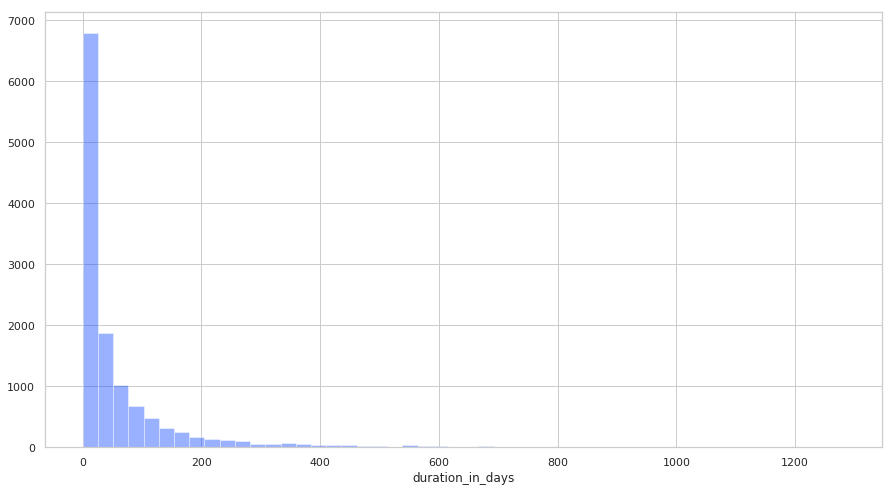

In [0]:
#Afficher un histogramme de cette durée afin de mieux voir les "valeurs aberrantes"
x = data_time["duration_in_days"].loc[data_time['exit_time']!= 'no_exit']
sns.set(style="whitegrid", palette = 'bright')
sns.distplot(x, kde=False, rug=False)

In [0]:
#Filtrer maintenant uniquement les ticket dont la durée est <700 jours 
data_inf_700days = data_time.loc[data_time['duration_in_days']< 700]
print(len(data_inf_700days))
data_inf_700days.head(5)

12425


,work_item,entry_time,exit_time,duration,duration_in_days
0,WI_000001,2015-01-02 14:39:14,2015-01-27 11:36:51,24 days 20:57:37,24.87
1,WI_000002,2015-01-02 15:04:20,2015-01-14 09:46:37,11 days 18:42:17,11.78
2,WI_000003,2015-01-02 15:28:22,2015-02-26 11:50:37,54 days 20:22:15,54.85
3,WI_000004,2015-01-02 15:33:54,2015-01-28 09:11:05,25 days 17:37:11,25.73
4,WI_000005,2015-01-02 16:32:11,2015-02-04 12:57:49,32 days 20:25:38,32.85


In [0]:
#Quelle est la répartition de ces derniers par rapports au total ? 
nbr_ticket = len(data_inf_700days) #12425
pourcentage = round((len(data_inf_700days) / len(data_time)) * 100, 3) #90.713%

print('Il y a {}% de ticket dont la durée est < à 700jours,'.format(pourcentage))
print('Soit {} tickets'.format(nbr_ticket))

Il y a 90.713% de ticket dont la durée est < à 700jours,
Soit 12425 tickets


In [0]:
#Compter le nombre de jours pour gérer les 10 premiers `work_item`
nbr_10eritems = int(data_inf_700days['duration_in_days'][0:10].sum())
print('{} days of work pour les 10 premiers work_item'.format(nbr_10eritems)) #259

259 days of work pour les 10 premiers work_item


____________________________________________

## Feature Engineering n°2 : Agrégation (suite)

Avec cette base de données agrégée, nous pouvons désormais facilement compter les éléments de travail par jour en utilisant l'opération `resample ()`.

* Remarque: * * `resample ()` est similaire à `groupby ()` **mais fonctionne avec les données datetime**.

Nous allons commencer par calculer les comptes quotidiens de : 
- éléments de travail ouverts pendant la journée
- éléments de travail fermés pendant la journée
- éléments de travail restant ouverts jusqu'à la fin de la période

In [0]:
#Agréger les données par jours 
#Filtrer les éléments qui sont toujours ouvert à la fin de la période (WIP)

#saison 2 : comment modéliser ce taux de fermeture journalier (meilleur quand il est petit)

data_inf_700 = data.loc[data['work_item'].isin(data_inf_700days['work_item'])]
test = data_inf_700.copy()

#test = data.copy()
test.rename(columns={'timestamp': "date"}, inplace = True) #ajouter un groupby avant pour les duplicate + test avec verify integrety
test.set_index(['date'], inplace = True)  #use date as index
test.index = pd.to_datetime(test.index, unit='d') #transf the index in day unit
test = test.ix[:, ['from_phase', 'to_phase', 'work_item']] #keep the needed columns

liste_open = []
liste_close = []

# Encode opened
for x in test.index : 
  if str(test['from_phase'][x]) == 'nan' : liste_open.append(1)
  else : liste_open.append(0)

# Encode closed
for x in test.index : 
  if str(test['to_phase'][x]) == 'nan' : liste_close.append(1)
  else : liste_close.append(0)

# Store the values in the new dataset and resample at a frequency of one day
test['opened_day'] = liste_open
test['closed_day'] = liste_close
new_dataset = test.resample('D').sum()

# Encode remain open : nbr cumulated of ticket still openned at that date 
#(=cumulated openned - cummulated closed) from the beginning to that day
liste_remain = np.zeros(len(new_dataset), dtype=int)
new_dataset['remain_open'] = liste_remain
for x in new_dataset.index :
  new_dataset['remain_open'][x] = new_dataset['opened_day'][new_dataset.index[0]:x].sum() - new_dataset['closed_day'][new_dataset.index[0]:x].sum()

new_dataset.head(10)

,opened_day,closed_day,remain_open
date,,,
2015-01-02,6,0,6
2015-01-03,1,0,7
2015-01-04,2,0,9
2015-01-05,22,0,31
2015-01-06,17,7,41
2015-01-07,5,0,46
2015-01-08,4,3,47
2015-01-09,3,1,49
2015-01-10,2,0,51


## Répartition des tickets 

In [0]:
#Afficher les stats descriptive de ce nouveau dataset 

# Compute column remain_open only for the last day of the dataset
liste_remain = np.zeros(len(new_dataset), dtype=int)
new_dataset['remain_open'] = liste_remain
x = new_dataset.index[-1]
new_dataset['remain_open'][x] = new_dataset['opened_day'][new_dataset.index[0]:x].sum() - new_dataset['closed_day'][new_dataset.index[0]:x].sum()
  
new_dataset.describe()

,opened_day,closed_day,remain_open
count,1429.000000,1429.000000,1429.000000
mean,8.671798,8.305808,0.365990
std,8.288102,9.516364,13.835204
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,8.000000,6.000000,0.000000
75%,14.000000,13.000000,0.000000
max,64.000000,60.000000,523.000000


In [0]:
#Compter pour chaque jour le nombre de ticker ouvert (somme cumulée des ouverture)

# Compute cumulated sum of openned ticket for each day
liste = []
for x in new_dataset.index:
  liste.append(new_dataset['opened_day'][new_dataset.index[0]:x].sum())

# Store the value in a pandas series
opened_day = pd.Series(liste, name='opened_day')
opened_day.head()

0     6
1     7
2     9
3    31
4    48
Name: opened_day, dtype: int64